## MLP model using Molecular Fingerprints to Predict S1 & T1 Energies

The dataset has been pre-processed by Kim et al. and was taken from [this paper](https://doi.org/10.1002/bkcs.12516) (DOI: 10.1002/bkcs.12516).  

The pre-processed data in `TADF_data_DL.txt` has the following format:

    ID | SMILES | HOMO | LUMO | E(S1) | E(T1)

The goal of this project is to predict the S1 and T1 energies using differenet combinations of molecular representations & ML models.

First, the necessary libraries are imported:
- torch for general PyTorch functionality
- torch.nn for neural network based functionalities
- torch.utils.data for handling the dataset
- torch.optim for the optimize which will update the parameters of the neural network
- torch.metrics.R2Score to assess the accuracy of the model
- rdkit.chem to obtain the molecular fingerprints from the SMILES
- matplotlib & seaborn for plotting

This notebook aims to recreate the MLP model employed in the literature

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torcheval.metrics import R2Score

from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import pandas as pd
import numpy as np

import random
import time

In [3]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
class MFDataset(Dataset):

    def __init__(self, fn, length = None):
        # Data Loading
        loaded_data = pd.read_csv(fn, sep ="\t", header=None)
        all_data = loaded_data[:length]
        self.data = all_data #Return all data as dataframe

        #Manipulate data using Pandas & RDkit
        all_data.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]
        filt_data = all_data.drop(columns = ["ID", "LUMO", "HOMO"])
        filt_data["MOL"] = filt_data["SMILES"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects

        def calculate_MFP(molecule):
            fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 3, nBits=1024)
            nf = fp.ToList()
            return nf
        
        filt_data["MFP"] = filt_data["MOL"].apply(calculate_MFP)

        mfps = np.array(filt_data["MFP"].tolist())
        #e_s1 = np.array(filt_data["E(S1)"])
        #e_t1 = np.array(filt_data["E(T1)"])

        energies = np.column_stack((filt_data["E(S1)"], filt_data["E(T1)"]))
        
        self.mfps = mfps #Vector of Morgan fingerprints (X by 1024)
        self.energies = energies # Matrix of S1 & T1 energies(X by 2)
        self.n_samples = filt_data.shape[0] #number of data_points

    def __getitem__(self, index):
        # dataset[0]

        return self.mfps[index], self.energies[index]

        """
        energy_dict = dict()

        energy_dict["FP"] = self.mfps[index]
        energy_dict["Energies"] = self.energies[index]

        return energy_dict
        """

    def __len__(self):
        # Length of Dataset
        return self.n_samples

Once the custom dataset class has been created, the data is loaded and split into 8:1:1 for training, validation, & testing sets.

In [41]:
path = "./data/TADF_data_DL.txt" #location of data

full_dataset = MFDataset(path)

#Splitting dataset 8:1:1
total_size = len(full_dataset)
train_size = int(0.8*total_size)
validation_size = int(0.1*total_size)
test_size = total_size - (train_size + validation_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])

#Create DataLoaders for training, validation, & testing
bs = 32

train_dataloader = DataLoader(train_dataset, batch_size = bs, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = bs, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = bs, shuffle = False)

# Defining the Model
The model used will be a neural network, specifially a multilayer perceptron (MLP). The hyperparameters for the MLP employed by Kim, Kim, & Kim are shown below:

- Dimension of hidden layers: 1869
- Number of hidden layers: 7
- Dropout p: 0.0
- Number of linear layers of predictor: 1
- Learning rate: 10<sup>-3.5075</sup>   

In [42]:
e = 10**-3.5075
print(e)

0.0003108135902739477


In [31]:
#Layers building block
class MLP(nn.Module):
    def __init__(self, in_feature, out_feature, dropout):
        super().__init__()
        self.in_feature = in_feature
        self.dropout = dropout
        self.Linear=nn.Linear(in_feature,out_feature)
        self.dropout = nn.Dropout(p=self.dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        skip_x = x
        x = self.Linear(x)
        x = self.dropout(x)
        x = x+skip_x
        x = self.activation(x)

        return x

#Fingerprint MLP model
class FpMLP(nn.Module):
    def __init__(self, args):
        super(FpMLP, self).__init__()

        # Argument Define
        self.dim_of_fp = args["fp_dim"]
        self.dim_of_Linear = args["hidden_dim"]

        self.N_predict_layer = args["N_MLP_layer"]
        self.N_predict_FC = args["N_predictor_layer"]

        self.N_properties = args["N_properties"]

        self.dropout = args["dropout"]

        self.embedding=nn.Linear(self.dim_of_fp,self.dim_of_Linear)

        self.MLPs= nn.ModuleList([
            MLP(self.dim_of_Linear,self.dim_of_Linear,self.dropout) for _ in range(self.N_predict_layer)])

        self.predict = \
            nn.ModuleList([
                nn.Sequential(nn.Linear(self.dim_of_Linear,self.dim_of_Linear),
                              nn.Dropout(p=self.dropout),
                              nn.ReLU())
                for _ in range(self.N_predict_FC-1)] +
                [nn.Linear(self.dim_of_Linear,self.N_properties)
            ])

    def forward(self, x):
        x = self.embedding(x)

        for layer in self.MLPs:
            x = layer(x)

        for layer in self.predict:
            x = layer(x)
        return x

### Training

In [66]:
#Define model hyperparameters, learning rate, & criterion
config = {
    "fp_dim": 1024,
    "hidden_dim": 100, #1869 in literature
    "N_MLP_layer": 10, #7 in literature
    "N_predictor_layer": 1, #1 in literature
    "N_properties": 2, #S1 & T1 energies
    "dropout": 0, #0 in literature
    "learning_rate": 0.003,
    "criterion": nn.SmoothL1Loss() #L1 used in literature
}

model = FpMLP(config)


learning_rate = config["learning_rate"]
criterion = config["criterion"]
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


#Traing loop
def train(model, iterator, optimizer, loss_funct):
    
    epoch_loss = 0
    r2_score = 0
    model.train() #Set model to training mode

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(torch.float32) #MFP
        y = y.to(torch.float32) #S1 & T1 energies

        optimizer.zero_grad() #clears gradients calculated from last batch
        
        #Forward pass
        y_pred = model(x)

        #Compute the loss
        loss = loss_funct(y_pred, y)

        #Backpropragation
        loss.backward() #claculate gradient of loss
        optimizer.step() #update parameters by taking an optimizer step

        r2 = R2Score()
        r2.update(y_pred,y)
        r2_score += float(r2.compute())

        epoch_loss += loss.item()

    return epoch_loss / len(iterator), r2_score / len(iterator)

#Validation loop (similar to trainig loop but gradients are not calculated)
def evaluate(model, iterator, loss_funct):

    epoch_loss = 0
    r2_score = 0
    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(torch.float32) #MFP
            y = y.to(torch.float32) #S1 & T1 energies

            y_pred = model(x)
            loss = loss_funct(y_pred, y)

            r2 = R2Score()
            r2.update(y_pred,y)
            r2_score += float(r2.compute())

            epoch_loss += loss.item()

    return epoch_loss / len(iterator), r2_score / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#function to save model when best validation loss is found
def save_model(model, config, filename):
    state = {
        "config": config,
        "model_state_dict": model.state_dict()
    }
    torch.save(state, filename)

In [55]:
epochs = 100 #100 in literature

best_valid_loss = float('inf')

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc="Training Model", unit="epoch"):
    start_time = time.monotonic()

    train_loss, train_r2 = train(model, train_dataloader, optimizer, criterion)
    valid_loss, val_r2 = evaluate(model, val_dataloader, criterion)

    train_losses.append(float(train_loss))
    val_losses.append(float(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_model(model, config, "./models/model_3.pt")

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f}")
        print(f"\tTrain R2: {train_r2:.3f}")
        print(f"\tVal. Loss: {valid_loss:.3f}")
        print(f"\tVal. R2: {val_r2:.3f}")

Training Model:   1%|          | 1/100 [00:15<26:14, 15.90s/epoch]

Epoch: 0 | Epoch Time: 0m 15s
	Train Loss: 0.130
	Train R2: 0.193
	Val. Loss: 0.097
	Val. R2: 0.471


Training Model:  11%|█         | 11/100 [06:40<57:19, 38.65s/epoch] 

Epoch: 10 | Epoch Time: 0m 49s
	Train Loss: 0.041
	Train R2: 0.771
	Val. Loss: 0.083
	Val. R2: 0.548


Training Model:  21%|██        | 21/100 [12:02<45:29, 34.55s/epoch]

Epoch: 20 | Epoch Time: 0m 39s
	Train Loss: 0.025
	Train R2: 0.855
	Val. Loss: 0.088
	Val. R2: 0.520


Training Model:  31%|███       | 31/100 [17:00<36:26, 31.69s/epoch]

Epoch: 30 | Epoch Time: 0m 37s
	Train Loss: 0.018
	Train R2: 0.891
	Val. Loss: 0.090
	Val. R2: 0.513


Training Model:  41%|████      | 41/100 [22:20<33:56, 34.51s/epoch]

Epoch: 40 | Epoch Time: 0m 41s
	Train Loss: 0.014
	Train R2: 0.913
	Val. Loss: 0.091
	Val. R2: 0.505


Training Model:  51%|█████     | 51/100 [27:31<26:02, 31.89s/epoch]

Epoch: 50 | Epoch Time: 0m 37s
	Train Loss: 0.013
	Train R2: 0.924
	Val. Loss: 0.090
	Val. R2: 0.512


Training Model:  61%|██████    | 61/100 [32:17<19:53, 30.61s/epoch]

Epoch: 60 | Epoch Time: 0m 34s
	Train Loss: 0.011
	Train R2: 0.935
	Val. Loss: 0.092
	Val. R2: 0.503


Training Model:  71%|███████   | 71/100 [38:07<17:53, 37.00s/epoch]

Epoch: 70 | Epoch Time: 0m 37s
	Train Loss: 0.009
	Train R2: 0.943
	Val. Loss: 0.095
	Val. R2: 0.477


Training Model:  81%|████████  | 81/100 [43:20<09:10, 28.99s/epoch]

Epoch: 80 | Epoch Time: 0m 30s
	Train Loss: 0.008
	Train R2: 0.951
	Val. Loss: 0.096
	Val. R2: 0.473


Training Model:  91%|█████████ | 91/100 [47:13<03:34, 23.87s/epoch]

Epoch: 90 | Epoch Time: 0m 22s
	Train Loss: 0.007
	Train R2: 0.955
	Val. Loss: 0.094
	Val. R2: 0.489


Training Model: 100%|██████████| 100/100 [50:31<00:00, 30.32s/epoch]


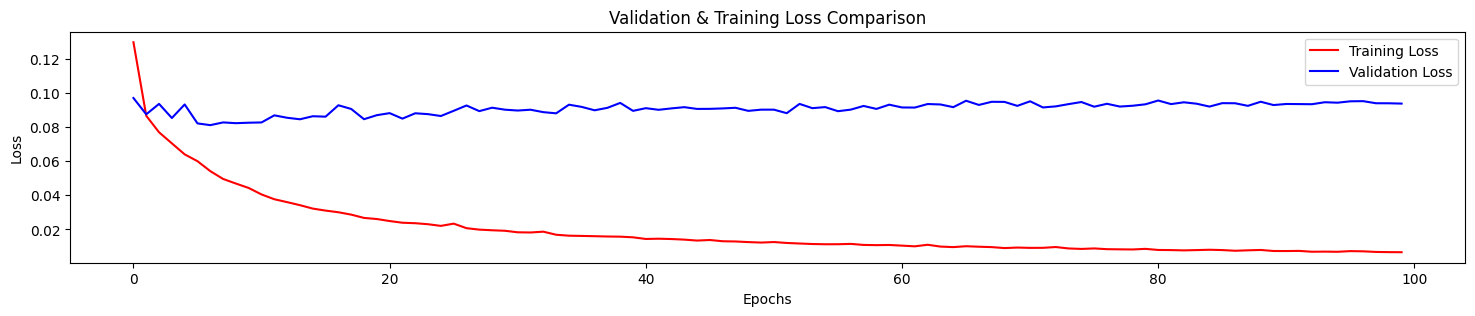

In [56]:
plt.figure(figsize=(18, 3)) 

# Plot the first line
plt.plot(train_losses, c="red", label="Training Loss")

# Plot the second line
plt.plot(val_losses, c="blue", label="Validation Loss")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation & Training Loss Comparison")
plt.legend()  # Show legend with labels

plt.show()

In [58]:
model.load_state_dict(torch.load("./models/model_3.pt"))

test_loss, test_r2 = evaluate(model, test_dataloader, criterion)
print(f"MSE on test set:  {test_loss:.4f}")
print(f"R2 score on test set:  {test_r2:.4f}")

Evaluating:   0%|          | 0/132 [00:00<?, ?it/s]

MSE on test set:  0.0789
R2 score on test set:  0.5656


Model_2 hyperparameters:
```
args = {
    "fp_dim": 1024,
    "hidden_dim": 64, #1869 in literature
    "N_MLP_layer": 7, #7 in literature
    "N_predictor_layer": 1, #1 in literature
    "N_properties": 2, #S1 & T1 energies
    "dropout": 0 #0 in literature
}

learning_rate = 10**-3.5075
criterion = nn.L1Loss() #L1 used in literature
```

In [68]:
#Load model with specific configurations
"""
def load_model_and_config(model,filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    config = checkpoint["config"]
    return model, config

#Example usage:
loaded_model = FpMLP(config)
loaded_model, loaded_config = load_model_and_config(loaded_model, pathname)

#Retrieve and print hyperparameters and settings
print("Loaded Configuration:")
for key, value in loaded_config.items():
    print(f"{key}: {value}")
"""

'\ndef load_model_and_config(model,filename):\n    checkpoint = torch.load(filename)\n    model.load_state_dict(checkpoint["model_state_dict"])\n    model.eval()\n\n    config = checkpoint["config"]\n    return model, config\n\n#Example usage:\nloaded_model = FpMLP(config)\nloaded_model, loaded_config = load_model_and_config(loaded_model, pathname)\n\n#Retrieve and print hyperparameters and settings\nprint("Loaded Configuration:")\nfor key, value in loaded_config.items():\n    print(f"{key}: {value}")\n'